In [1]:
import torch

import sys
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def dist_metric(x,y):
    return(torch.norm(x-y).item())

def calculate_action(dist_list,k):
    action = torch.tensor([0.0,0.0,0.0])
    top_k_weights = torch.zeros((k,))
    for i in range(k):
        top_k_weights[i] = dist_list[i][0]

    top_k_weights = softmax(-1*top_k_weights)
    for i in range(k):
        action = torch.add(top_k_weights[i]*dist_list[i][1], action)

    return(action)

In [14]:
params = {}
params['root_dir'] = '/home/jyo/non_parametric_imitation/'
params['img_size'] = 224
params['layer'] = 'avgpool'
params['model'] = 'BYOL'
params['representation_model_path'] = 'chkpts/BYOL_100_resnet.pt'
params['eval'] = 0
params['representation'] = 0
params['dataset'] = 'PushDataset'
params['architecture'] = 'ResNet'
params['t'] = 10
 

sys.path.append(params['root_dir'] + 'representation_models')
sys.path.append(params['root_dir'] + 'dataloaders')
from run_model import Encoder
from PushDataset_temporal import PushDatasetTemporal

encoder = Encoder(params)
params['folder'] = '/home/jyo/non_parametric_imitation/representation_data/push_data/train'
train_dataset = PushDatasetTemporal(params, encoder)
params['folder'] =  '/home/jyo/non_parametric_imitation/representation_data/push_data/val'
val_dataset = PushDatasetTemporal(params, encoder)
params['folder'] =  '/home/jyo/non_parametric_imitation/representation_data/push_data/test'
test_dataset = PushDatasetTemporal(params, encoder)

100%|██████████| 92/92 [03:41<00:00,  2.41s/it]


In [15]:
mseLoss = torch.nn.MSELoss()
softmax = torch.nn.Softmax(dim=0)

In [16]:
def calculate_nearest_neighbors(query_set, dataset, k):
    loss = [0 for i in range(k)]

    for query_index in tqdm(range(len(query_set))):
        dist_list = []
        query_embedding, query_action, query_path = query_set[query_index]

        for dataset_index in range(len(dataset)):

            dataset_embedding, dataset_action, dataset_path = dataset[dataset_index]
            distance = dist_metric(query_embedding, dataset_embedding)
            dist_list.append((distance, dataset_action, dataset_path))

        dist_list = sorted(dist_list, key = lambda tup: tup[0])
        #random.shuffle(dist_list)
        #if(query_index%100 == 0):
            #print(query_path, dist_list[0][2], dist_list[0][0])
        
        for i in range(k):
            pred_action = calculate_action(dist_list, i+1)
            loss[i] += mseLoss(pred_action,query_action).item()

    return(loss)

In [18]:
val_loss = calculate_nearest_neighbors(val_dataset, train_dataset, 50)

100%|██████████| 708/708 [04:46<00:00,  2.47it/s]


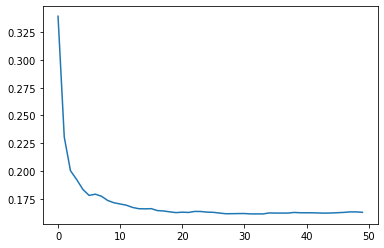

In [19]:
val_loss_scaled = [i / len(val_dataset) for i in val_loss]
x_axis = [i for i in range(len(val_loss))]
plt.plot(x_axis, val_loss_scaled)

In [20]:
min(val_loss_scaled)

0.16129502959338862

In [21]:
test_loss = calculate_nearest_neighbors(test_dataset, train_dataset, 200)

100%|██████████| 404/404 [04:21<00:00,  1.54it/s]


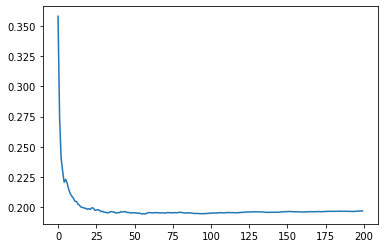

In [22]:
test_loss_scaled = [i / len(test_dataset) for i in test_loss]
x_axis = [i for i in range(len(test_loss))]
plt.plot(x_axis, test_loss_scaled)

In [23]:
min(test_loss_scaled)

0.19428218364976935